In [1]:
import pandas as pd

In [2]:
df_final2 = pd.read_csv('Dataset2.CSV')

In [3]:
df_final2.columns

Index(['Age', 'Draft_col', 'Month_Draft', 'Fix_Cost', 'Length_Service',
       'Length_MEC', 'Money_Stat', 'Credit_Hist', 'Last_Credit', 'Loan_Amount',
       'Amount_giv', 'Duration', 'Market&Env_Context', 'Current_Situation',
       'Sex_MASCULIN', 'Own_Prop_OUI', 'Mrt_St_not married', 'Oth_Act_OUI',
       'Finantial_Guarantee_OUI', 'Type_Cult_maraîchage', 'Area_over 01ha',
       'Active3month_past_OUI', 'Proof_Act_OUI', 'Morality_Mavaise'],
      dtype='object')

### Create 4 folds of (75%,25%)

In [4]:
from sklearn.model_selection import KFold

# Define feature columns (X) and target column (y)
X = df_final2.drop('Current_Situation', axis=1)  # Replace 'target_column_name' with your actual target column name
y = df_final2['Current_Situation']

# Initialize KFold with 4 splits
kf = KFold(n_splits=4, shuffle=True, random_state=42)

X_train_folds = []
X_test_folds = []
y_train_folds = []
y_test_folds = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_folds.append(X_train)
    X_test_folds.append(X_test)
    y_train_folds.append(y_train)
    y_test_folds.append(y_test)

    print(f"Fold {i+1}:")
    print(f"Training set shape: {X_train.shape}, {y_train.shape}")
    print(f"Testing set shape: {X_test.shape}, {y_test.shape}")
    print("-" * 40)


Fold 1:
Training set shape: (75, 23), (75,)
Testing set shape: (25, 23), (25,)
----------------------------------------
Fold 2:
Training set shape: (75, 23), (75,)
Testing set shape: (25, 23), (25,)
----------------------------------------
Fold 3:
Training set shape: (75, 23), (75,)
Testing set shape: (25, 23), (25,)
----------------------------------------
Fold 4:
Training set shape: (75, 23), (75,)
Testing set shape: (25, 23), (25,)
----------------------------------------


# Model Development (Here we are!)

To apply and compare several machine learning models on our pre-processed dataset for credit risk prediction, we will follow the tutorial provided using a pipeline. We will include logistic regression and k-nearest neighbour models, and add additional models commonly used for this type of problem. We will also set up a hyperparameter search to optimise these models.

## Step 1: Import the required packages

In [5]:
# ___Cell no. 1___
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier  # New addition for Decision Tree
from sklearn.naive_bayes import GaussianNB  # New addition for Naive Bayes
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # Added metrics for evaluation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 2: Define the machine learning models and their hyperparameters

In [6]:
# ___Cell no. 2___
lr = LogisticRegression()  # Logistic Regression
knn = KNeighborsClassifier()  # K-Nearest Neighbors
rf = RandomForestClassifier()  # Random Forest
svc = SVC(probability=True)  # Support Vector Machine
dt = DecisionTreeClassifier()  # Decision Tree (new addition)
nb = GaussianNB()  # Naive Bayes (new addition)

# Updated list of models and identifiers
models = [[lr, 'lrFI'], [knn, 'knn'], [rf, 'rf'], [svc, 'svc'], [dt, 'dt'], [nb, 'nb']]


## Step 3: Define hyperparameters for grid search

In [7]:
# ___Cell no. 3___
lrFI_par = {
    'solver': ['newton-cg', 'liblinear'],
    'penalty': ['l2'],
    'C': [16.0, 4.0, 1.0, 0.25],
    'fit_intercept': [True]
}

knn_par = {'n_neighbors': [3, 5, 7, 9]}
rf_par = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
svc_par = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
dt_par = {'max_depth': [None, 10, 20], 'min_samples_split': [2, 10, 20]}  # Hyperparameters for Decision Tree
nb_par = {}  # No hyperparameters needed for Naive Bayes

# Updated list of hyperparameters for all models
parameters = [lrFI_par, knn_par, rf_par, svc_par, dt_par, nb_par]

## Step 4: Define training and test sets

In [8]:
# ___Cell no. 4___
# features = [feature set]

# feature set1 = All feature set, feature set2 = Lasso feature set, feature set3 = Forward feature set 
features = [ ['Age', 'Draft_col', 'Month_Draft', 'Fix_Cost', 'Length_Service','Length_MEC', 'Money_Stat', 'Credit_Hist', 'Last_Credit', 'Loan_Amount','Amount_giv', 'Duration', 'Market&Env_Context', 'Sex_MASCULIN', 'Own_Prop_OUI', 'Mrt_St_not married', 'Oth_Act_OUI','Finantial_Guarantee_OUI', 'Type_Cult_maraîchage', 'Area_over 01ha','Active3month_past_OUI', 'Proof_Act_OUI', 'Morality_Mavaise'], ["Market&Env_Context", "Last_Credit","Money_Stat" ,"Fix_Cost"], ['Age', 'Draft_col', 'Length_Service', 'Length_MEC', 'Credit_Hist','Market&Env_Context', 'Sex_MASCULIN', 'Own_Prop_OUI','Mrt_St_not married'] ]  # Exemples de caractéristiques
#splits = 0.3  # Fraction de l'ensemble de test

## Step 5: Model evaluation function with cross-validation

In [9]:
# ___Cell no. 5___

def cv(m, p, xtrain, ytrain, xtest, ytest):
    inner_cv = StratifiedKFold(n_splits=5)
    clf = GridSearchCV(m, p, scoring='accuracy', n_jobs=-1, cv=inner_cv, refit=True, verbose=0)
    clf.fit(xtrain, ytrain)
    yPred = clf.predict(xtest)
    Accuracy = accuracy_score(ytest, yPred)
    precision = precision_score(ytest, yPred)
    recall = recall_score(ytest, yPred)
    f1 = f1_score(ytest, yPred)
    ROC = roc_auc_score(ytest, yPred)
    return Accuracy, precision, recall, f1, ROC, clf,yPred

def get_accuracy_ml(m, p, xTrain, yTrain, xTest, yTest):
    accTot, pre_Tot, recall_Tot, f1_Tot, ROC_Tot, clfTot, yPred = cv(m, p, xTrain, yTrain, xTest, yTest)
    nxtr, nxte = len(yTrain), len(yTest)
    jackTrainArr, jackTestArr = np.zeros(nxtr), np.zeros(nxte)

    for i in range(nxtr):
        x_train, y_train = np.delete(np.array(xTrain), i, 0), np.delete(np.array(yTrain), i, 0)
        clfTot.fit(x_train, y_train)
        yPredJack = clfTot.predict(xTest)
        jackTrainArr[i] = accuracy_score(yTest, yPredJack)

    for i in range(nxte):
        x_test, y_test = np.delete(np.array(xTest), i, 0), np.delete(np.array(yTest), i, 0)
        clfTot.fit(xTrain, yTrain)
        yPredJack = clfTot.predict(x_test)
        jackTestArr[i] = accuracy_score(y_test, yPredJack)

    jackTrainSD = np.std(jackTrainArr)
    jackTestSD = np.std(jackTestArr)
    jackTotSD = np.sqrt(jackTrainSD**2 + jackTestSD**2)

    return accTot,pre_Tot, recall_Tot, f1_Tot, ROC_Tot, jackTrainSD, jackTestSD, jackTotSD,yPred,clfTot

## Step 6: Initialise the results dictionary

In [10]:
# ___Cell no. 6___

ml_dicts = {}

## Step 7: Loop for evaluating models

In [11]:

# Iterate over models and corresponding parameters
for m_idx, (m, par) in enumerate(zip(models, parameters)):
    key0 = f"model_{m_idx+1}"  # Create a key for the model (e.g., 'model_1', 'model_2')
    ml_dicts[key0] = {}  # Initialize a dictionary for this model
    
    # Iterate over feature sets
    for f_idx, f in enumerate(features):
        key1 = f"feature_set_{f_idx+1}"  # Create a key for the feature set (e.g., 'feature_set_1')
        ml_dicts[key0][key1] = {}  # Initialize a dictionary for this feature set
        
        # Iterate over the 4 folds from the cross-validation splits
        for fold_idx in range(4):
            # Select the training and testing sets for the current fold
            xtr, xte = X_train_folds[fold_idx][f], X_test_folds[fold_idx][f]  # Select features for this fold
            ytr, yte = y_train_folds[fold_idx], y_test_folds[fold_idx]  # Target variable
            
            # Call the 'cv' function with the model, parameters, and the current fold's train/test sets
            accTot, pre_Tot, recall_Tot, f1_Tot, ROC_Tot, clfTot, yPred = cv(m[0], par, xtr, ytr, xte, yte)
            
            # Create a fold key (e.g., 'fold_1', 'fold_2')
            key2 = f"fold_{fold_idx+1}"
            
            # Store the results in the dictionary under the model -> feature set -> fold
            ml_dicts[key0][key1][key2] = {
                'tot_acc': accTot,
                'pre_Tot': pre_Tot,
                'recall_Tot': recall_Tot,
                'f1_Tot': f1_Tot,
                'ROC_Tot': ROC_Tot,
                'jack_trainSD': None,  # Replace 'None' with the actual value if calculated
                'jack_testSD': None,   # Replace 'None' with the actual value if calculated
                'jack_totSD': None,    # Replace 'None' with the actual value if calculated
                'yPred': yPred,
                'model': clfTot
            }

        # Print to track progress
        print(f"Completed {key0} for {key1}")

# Now you have a three-level dictionary: model -> feature set -> fold with the results.


Completed model_1 for feature_set_1
Completed model_1 for feature_set_2
Completed model_1 for feature_set_3
Completed model_2 for feature_set_1
Completed model_2 for feature_set_2
Completed model_2 for feature_set_3
Completed model_3 for feature_set_1
Completed model_3 for feature_set_2
Completed model_3 for feature_set_3
Completed model_4 for feature_set_1
Completed model_4 for feature_set_2
Completed model_4 for feature_set_3
Completed model_5 for feature_set_1
Completed model_5 for feature_set_2
Completed model_5 for feature_set_3
Completed model_6 for feature_set_1
Completed model_6 for feature_set_2
Completed model_6 for feature_set_3


### Print results

In [12]:
# Initialize an empty dictionary to store data for each model's table
table_data = {}

# Iterate through the dictionary and collect metrics for each model
for model_key, feature_dict in ml_dicts.items():
    rows = []  # List to collect rows of the table for each model
    # Iterate through feature sets and folds
    for feature_key, fold_dict in feature_dict.items():
        for fold_key, result_dict in fold_dict.items():
            # Create a row with the model, feature set, fold, and metrics
            row = {
                'Feature Set': feature_key,
                'Fold': fold_key,
                'Accuracy': result_dict['tot_acc'],
                'Precision': result_dict['pre_Tot'],
                'Recall': result_dict['recall_Tot'],
                'F1-Score': result_dict['f1_Tot'],
                'ROC-AUC': result_dict['ROC_Tot']
            }
            rows.append(row)
    
    # Convert rows to a DataFrame
    table_data[model_key] = pd.DataFrame(rows)

# Display the results for each model
for model_key, df in table_data.items():
    print(f"\nMetrics for {model_key}:\n")
    print(df)


Metrics for model_1:

      Feature Set    Fold  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0   feature_set_1  fold_1      0.88   0.750000  1.000000  0.857143  0.906250
1   feature_set_1  fold_2      0.84   0.857143  0.857143  0.857143  0.837662
2   feature_set_1  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
3   feature_set_1  fold_4      0.96   0.916667  1.000000  0.956522  0.964286
4   feature_set_2  fold_1      0.84   0.692308  1.000000  0.818182  0.875000
5   feature_set_2  fold_2      0.92   0.875000  1.000000  0.933333  0.909091
6   feature_set_2  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
7   feature_set_2  fold_4      0.92   0.846154  1.000000  0.916667  0.928571
8   feature_set_3  fold_1      0.80   0.700000  0.777778  0.736842  0.795139
9   feature_set_3  fold_2      0.96   0.933333  1.000000  0.965517  0.954545
10  feature_set_3  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
11  feature_set_3  fold_4      1.00   1.000000  1.000

### Metrics Average Across folds

In [13]:
import pandas as pd

# Initialize an empty dictionary to store data for each model's table
average_table_data = {}

# Iterate through the dictionary and collect metrics for each model
for model_key, feature_dict in ml_dicts.items():
    rows = []  # List to collect rows of the table for each model
    
    # Iterate through feature sets
    for feature_key, fold_dict in feature_dict.items():
        # Initialize lists to store metrics for each fold
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        roc_auc_list = []
        
        # Collect metrics for each fold
        for fold_key, result_dict in fold_dict.items():
            accuracy_list.append(result_dict['tot_acc'])
            precision_list.append(result_dict['pre_Tot'])
            recall_list.append(result_dict['recall_Tot'])
            f1_list.append(result_dict['f1_Tot'])
            roc_auc_list.append(result_dict['ROC_Tot'])
        
        # Calculate the average of the metrics across folds for this feature set
        row = {
            'Feature Set': feature_key,
            'Avg Accuracy': sum(accuracy_list) / len(accuracy_list),
            'Avg Precision': sum(precision_list) / len(precision_list),
            'Avg Recall': sum(recall_list) / len(recall_list),
            'Avg F1-Score': sum(f1_list) / len(f1_list),
            'Avg ROC-AUC': sum(roc_auc_list) / len(roc_auc_list)
        }
        rows.append(row)
    
    # Convert rows to a DataFrame for this model
    average_table_data[model_key] = pd.DataFrame(rows)

# Display the results for each model
for model_key, df in average_table_data.items():
    print(f"\nAverage Metrics for {model_key}:\n")
    print(df)


Average Metrics for model_1:

     Feature Set  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-Score  \
0  feature_set_1          0.89       0.839286    0.941558      0.885093   
1  feature_set_2          0.89       0.811699    0.977273      0.884437   
2  feature_set_3          0.91       0.866667    0.921717      0.892981   

   Avg ROC-AUC  
0     0.897829  
1     0.898945  
2     0.908200  

Average Metrics for model_2:

     Feature Set  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-Score  \
0  feature_set_1          0.90       0.841667    0.959416      0.894945   
1  feature_set_2          0.90       0.829327    0.977273      0.894401   
2  feature_set_3          0.91       0.866667    0.921717      0.892981   

   Avg ROC-AUC  
0     0.906757  
1     0.907873  
2     0.908200  

Average Metrics for model_3:

     Feature Set  Avg Accuracy  Avg Precision  Avg Recall  Avg F1-Score  \
0  feature_set_1          0.92       0.895542    0.941558      0.913781   
1  feature_set_2   

In [14]:
# Iterate through the dictionary and print results
for model_key, feature_dict in ml_dicts.items():
    print(f"{model_key}\n" + "="*12)  # Print the model key (e.g., 'model_1')
    
    for feature_key, fold_dict in feature_dict.items():
        print(f"  {feature_key}\n  " + "-"*10)  # Print the feature set key (e.g., 'feature_set_1')
        
        for fold_key, result_dict in fold_dict.items():
            print(f"    {fold_key}\n    " + "."*8)  # Print the fold key (e.g., 'fold_1')
            
            # Print the results for each fold
            for metric_key, metric_value in result_dict.items():
                print(f"      {metric_key}: {metric_value}")  # Print each metric
            print()  # Add a blank line for separation between folds


model_1
  feature_set_1
  ----------
    fold_1
    ........
      tot_acc: 0.88
      pre_Tot: 0.75
      recall_Tot: 1.0
      f1_Tot: 0.8571428571428571
      ROC_Tot: 0.90625
      jack_trainSD: None
      jack_testSD: None
      jack_totSD: None
      yPred: [1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1]
      model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [16.0, 4.0, 1.0, 0.25], 'fit_intercept': [True],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'liblinear']},
             scoring='accuracy')

    fold_2
    ........
      tot_acc: 0.84
      pre_Tot: 0.8571428571428571
      recall_Tot: 0.8571428571428571
      f1_Tot: 0.8571428571428571
      ROC_Tot: 0.8376623376623377
      jack_trainSD: None
      jack_testSD: None
      jack_totSD: None
      yPred: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0

             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='accuracy')

    fold_3
    ........
      tot_acc: 0.88
      pre_Tot: 0.8333333333333334
      recall_Tot: 0.9090909090909091
      f1_Tot: 0.8695652173913043
      ROC_Tot: 0.8831168831168832
      jack_trainSD: None
      jack_testSD: None
      jack_totSD: None
      yPred: [1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
      model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='accuracy')

    fold_4
    ........
      tot_acc: 0.96
      pre_Tot: 0.9166666666666666
      recall_Tot: 1.0
      f1_Tot: 0.9565217391304348
      ROC_Tot: 0.9642857142857143
      jack_trainSD: None
      jack_testSD: None
      jack_totSD: None
      yPred: [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0]
      model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None,

             scoring='accuracy')

    fold_2
    ........
      tot_acc: 0.96
      pre_Tot: 0.9333333333333333
      recall_Tot: 1.0
      f1_Tot: 0.9655172413793104
      ROC_Tot: 0.9545454545454545
      jack_trainSD: None
      jack_testSD: None
      jack_totSD: None
      yPred: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0]
      model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='accuracy')

    fold_3
    ........
      tot_acc: 0.88
      pre_Tot: 0.8333333333333334
      recall_Tot: 0.9090909090909091
      f1_Tot: 0.8695652173913043
      ROC_Tot: 0.8831168831168832
      jack_trainSD: None
      jack_testSD: None
      jack_totSD: None
      yPred: [1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0]
      model: GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=Fa

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store data for each model's table
table_data = {}
summary_data = {}

# Iterate through the dictionary and collect metrics for each model
for model_key, feature_dict in ml_dicts.items():
    rows = []  # List to collect rows of the table for each model
    summary_rows = []  # List to collect summary (mean, std) for each feature set
    
    # Iterate through feature sets and folds
    for feature_key, fold_dict in feature_dict.items():
        # Collect accuracies for each fold for this feature set
        accuracies = []
        for fold_key, result_dict in fold_dict.items():
            accuracies.append(result_dict['tot_acc'])
            
            # Add each fold's metrics to rows for detailed output
            row = {
                'Feature Set': feature_key,
                'Fold': fold_key,
                'Accuracy': result_dict['tot_acc'],
                'Precision': result_dict['pre_Tot'],
                'Recall': result_dict['recall_Tot'],
                'F1-Score': result_dict['f1_Tot'],
                'ROC-AUC': result_dict['ROC_Tot']
            }
            rows.append(row)
        
        # Calculate mean and standard deviation for accuracy for this feature set
        mean_acc = pd.Series(accuracies).mean()
        std_acc = pd.Series(accuracies).std()
        
        # Add summary metrics (mean, std) for each feature set
        summary_row = {
            'Feature Set': feature_key,
            'Mean Accuracy': mean_acc,
            'Std Accuracy': std_acc
        }
        summary_rows.append(summary_row)
    
    # Convert rows to DataFrame for detailed table
    table_data[model_key] = pd.DataFrame(rows)
    
    # Convert summary rows to DataFrame for mean/std table
    summary_data[model_key] = pd.DataFrame(summary_rows)

# Display the detailed results for each model
for model_key, df in table_data.items():
    print(f"\nDetailed Metrics for {model_key}:\n")
    print(df)

# Display the summary (mean/std) for each model
for model_key, summary_df in summary_data.items():
    print(f"\nSummary Metrics for {model_key} (Mean & Std of Accuracy):\n")
    print(summary_df)



Detailed Metrics for model_1:

      Feature Set    Fold  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0   feature_set_1  fold_1      0.88   0.750000  1.000000  0.857143  0.906250
1   feature_set_1  fold_2      0.84   0.857143  0.857143  0.857143  0.837662
2   feature_set_1  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
3   feature_set_1  fold_4      0.96   0.916667  1.000000  0.956522  0.964286
4   feature_set_2  fold_1      0.84   0.692308  1.000000  0.818182  0.875000
5   feature_set_2  fold_2      0.92   0.875000  1.000000  0.933333  0.909091
6   feature_set_2  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
7   feature_set_2  fold_4      0.92   0.846154  1.000000  0.916667  0.928571
8   feature_set_3  fold_1      0.80   0.700000  0.777778  0.736842  0.795139
9   feature_set_3  fold_2      0.96   0.933333  1.000000  0.965517  0.954545
10  feature_set_3  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
11  feature_set_3  fold_4      1.00   1.0000

## Plotting the results with error bars

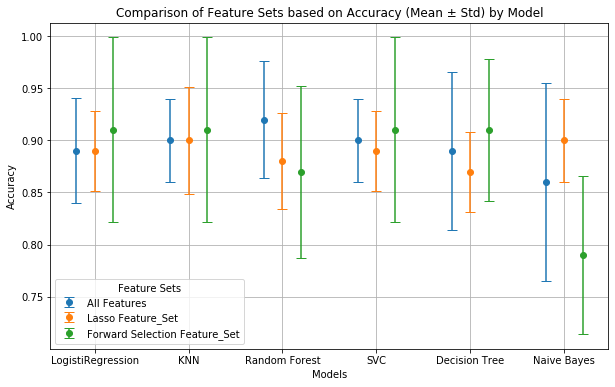

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the mean and std accuracy for each model and feature set
plt.figure(figsize=(10, 6))

# Create an index for the models (x-axis positions)
models = list(summary_data.keys())  #Get the model names
Almodel = ["LogistiRegression","KNN","Random Forest","SVC","Decision Tree","Naive Bayes"]
x_pos = np.arange(len(models))  # Create positions for models on the x-axis

# Width of the bars for each feature set
bar_width = 0.2
offset = 0  # Offset for each feature set on the x-axis

# Get the feature sets (assuming they are the same across models)
feature_sets = summary_data[models[0]]['Feature Set'].values
lop = ["All Features","Lasso Feature_Set","Forward Selection Feature_Set"]

# Plot each feature set's mean and std for each model
for feature_idx, feature_set in enumerate(feature_sets):
    mean_acc = [summary_data[model]['Mean Accuracy'].values[feature_idx] for model in models]
    std_acc = [summary_data[model]['Std Accuracy'].values[feature_idx] for model in models]

    # Plot the mean accuracy with error bars (std deviation) for each model
    plt.errorbar(
        x_pos + offset,  # X-axis: Adjust positions for each feature set
        mean_acc,  # Y-axis: Mean accuracy
        yerr=std_acc,  # Error bars: Std accuracy
        label= lop[feature_idx],  # Label for the feature set
        fmt='o',  # Format of the points and line
        capsize=5  # Size of error bar caps
    )
    
    # Shift the offset for the next feature set's plot
    offset += bar_width

# Set x-ticks to be the names of the models
plt.xticks(x_pos + bar_width * (len(feature_sets) - 1) / 2, Almodel)

# Add labels and title
plt.title('Comparison of Feature Sets based on Accuracy (Mean ± Std) by Model')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend(title="Feature Sets")
plt.grid(True)

# Show plot
plt.show()

### Calculate mean and standard deviation

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store data for each model's table
table_data = {}
summary_data = {}

# Iterate through the dictionary and collect metrics for each model
for model_key, feature_dict in ml_dicts.items():
    rows = []  # List to collect rows of the table for each model
    summary_rows = []  # List to collect summary (mean, std) for each feature set
    
    # Iterate through feature sets and folds
    for feature_key, fold_dict in feature_dict.items():
        # Collect metrics for each fold for this feature set
        accuracies = []
        precisions = []
        recalls = []
        f1_scores = []
        roc_aucs = []
        
        for fold_key, result_dict in fold_dict.items():
            accuracies.append(result_dict['tot_acc'])
            precisions.append(result_dict['pre_Tot'])
            recalls.append(result_dict['recall_Tot'])
            f1_scores.append(result_dict['f1_Tot'])
            roc_aucs.append(result_dict['ROC_Tot'])
            
            # Add each fold's metrics to rows for detailed output
            row = {
                'Feature Set': feature_key,
                'Fold': fold_key,
                'Accuracy': result_dict['tot_acc'],
                'Precision': result_dict['pre_Tot'],
                'Recall': result_dict['recall_Tot'],
                'F1-Score': result_dict['f1_Tot'],
                'ROC-AUC': result_dict['ROC_Tot']
            }
            rows.append(row)
        
        # Calculate mean and standard deviation for all metrics for this feature set
        mean_acc = pd.Series(accuracies).mean()
        std_acc = pd.Series(accuracies).std()
        
        mean_precision = pd.Series(precisions).mean()
        std_precision = pd.Series(precisions).std()
        
        mean_recall = pd.Series(recalls).mean()
        std_recall = pd.Series(recalls).std()
        
        mean_f1 = pd.Series(f1_scores).mean()
        std_f1 = pd.Series(f1_scores).std()
        
        mean_roc = pd.Series(roc_aucs).mean()
        std_roc = pd.Series(roc_aucs).std()
        
        # Add summary metrics (mean, std) for each feature set
        summary_row = {
            'Feature Set': feature_key,
            'Mean Accuracy': mean_acc,
            'Std Accuracy': std_acc,
            'Mean Precision': mean_precision,
            'Std Precision': std_precision,
            'Mean Recall': mean_recall,
            'Std Recall': std_recall,
            'Mean F1-Score': mean_f1,
            'Std F1-Score': std_f1,
            'Mean ROC-AUC': mean_roc,
            'Std ROC-AUC': std_roc
        }
        summary_rows.append(summary_row)
    
    # Convert rows to DataFrame for detailed table
    table_data[model_key] = pd.DataFrame(rows)
    
    # Convert summary rows to DataFrame for mean/std table
    summary_data[model_key] = pd.DataFrame(summary_rows)

# Display the detailed results for each model
for model_key, df in table_data.items():
    print(f"\nDetailed Metrics for {model_key}:\n")
    print(df)

# Display the summary (mean/std) for each model
for model_key, summary_df in summary_data.items():
    print(f"\nSummary Metrics for {model_key} (Mean & Std of all metrics):\n")
    print(summary_df)


Detailed Metrics for model_1:

      Feature Set    Fold  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0   feature_set_1  fold_1      0.88   0.750000  1.000000  0.857143  0.906250
1   feature_set_1  fold_2      0.84   0.857143  0.857143  0.857143  0.837662
2   feature_set_1  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
3   feature_set_1  fold_4      0.96   0.916667  1.000000  0.956522  0.964286
4   feature_set_2  fold_1      0.84   0.692308  1.000000  0.818182  0.875000
5   feature_set_2  fold_2      0.92   0.875000  1.000000  0.933333  0.909091
6   feature_set_2  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
7   feature_set_2  fold_4      0.92   0.846154  1.000000  0.916667  0.928571
8   feature_set_3  fold_1      0.80   0.700000  0.777778  0.736842  0.795139
9   feature_set_3  fold_2      0.96   0.933333  1.000000  0.965517  0.954545
10  feature_set_3  fold_3      0.88   0.833333  0.909091  0.869565  0.883117
11  feature_set_3  fold_4      1.00   1.0000

### Error bar for all Metrics

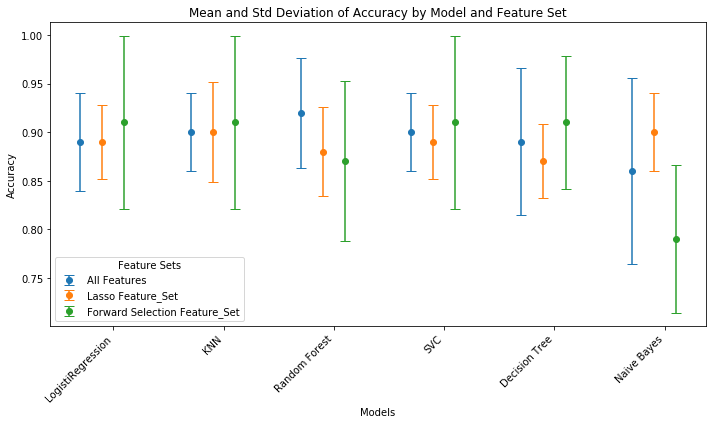

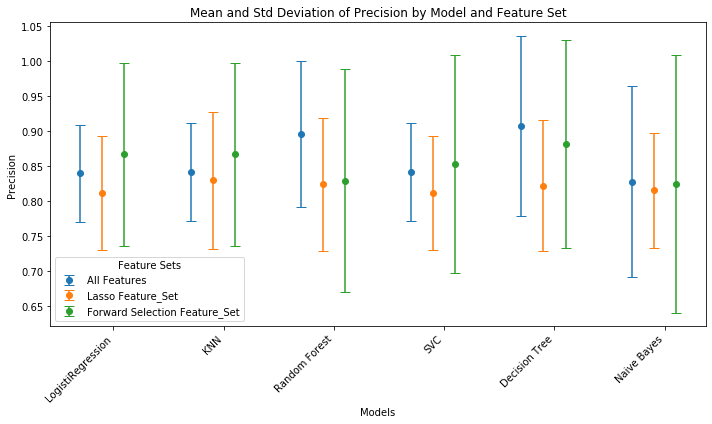

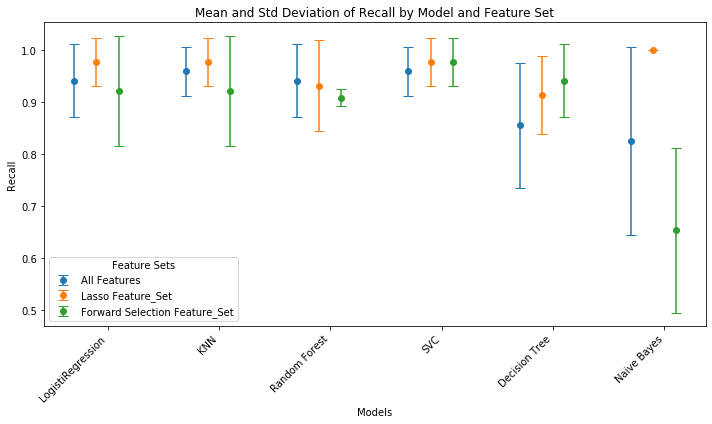

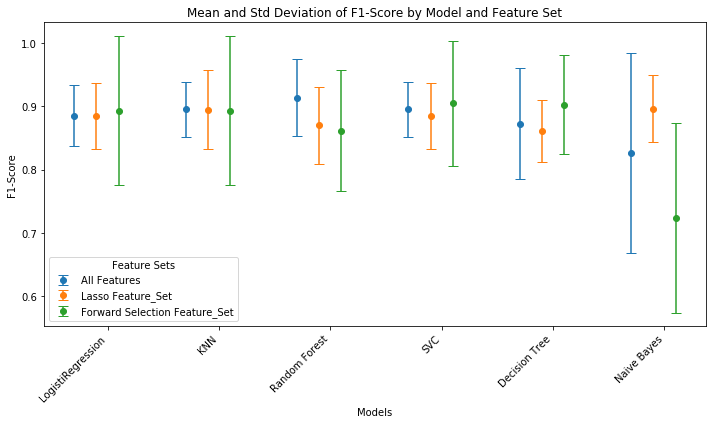

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot metric with error bars for each model
def plot_metric_by_model(metric_name, y_label):
    models = list(summary_data.keys())  #Liste des modèles
    Almodel = ["LogistiRegression","KNN","Random Forest","SVC","Decision Tree","Naive Bayes"]
    feature_sets = list(summary_data[models[0]]['Feature Set'])  # Liste des ensembles de caractéristiques
    
    x = np.arange(len(models))  # Positions X pour les modèles
    width = 0.2  # Largeur des barres pour chaque ensemble de caractéristiques

    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    lop = ["All Features","Lasso Feature_Set","Forward Selection Feature_Set"]
    # Plot each feature set's mean and std with error bars
    for feature_idx, feature_set in enumerate(feature_sets):
        mean_metric = [
            summary_data[model][f'Mean {metric_name}'].values[feature_idx] for model in models
        ]
        std_metric = [
            summary_data[model][f'Std {metric_name}'].values[feature_idx] for model in models
        ]
        
        # Shift the x positions slightly for each feature set to avoid overlap
        x_shifted = x + (feature_idx - len(feature_sets) / 2) * width
        
        # Plot error bars for the current feature set
        ax.errorbar(x_shifted, mean_metric, yerr=std_metric, fmt='o', label=lop[feature_idx], capsize=5)

    # Add labels and title
    ax.set_xlabel('Models')
    ax.set_ylabel(y_label)
    ax.set_title(f'Mean and Std Deviation of {metric_name} by Model and Feature Set')
    ax.set_xticks(x)
    ax.set_xticklabels(Almodel, rotation=45, ha="right")
    ax.legend(title="Feature Sets")
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Générer les graphiques pour chaque métrique
plot_metric_by_model('Accuracy', 'Accuracy')
plot_metric_by_model('Precision', 'Precision')
plot_metric_by_model('Recall', 'Recall')
plot_metric_by_model('F1-Score', 'F1-Score')
#plot_metric_by_model('ROC-AUC', 'ROC-AUC')


### Metrics across all models for each feature set

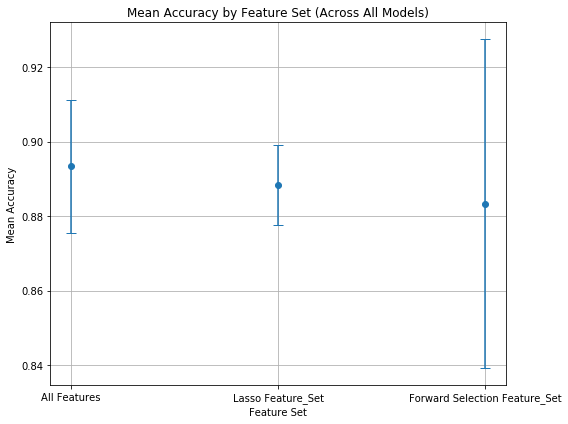

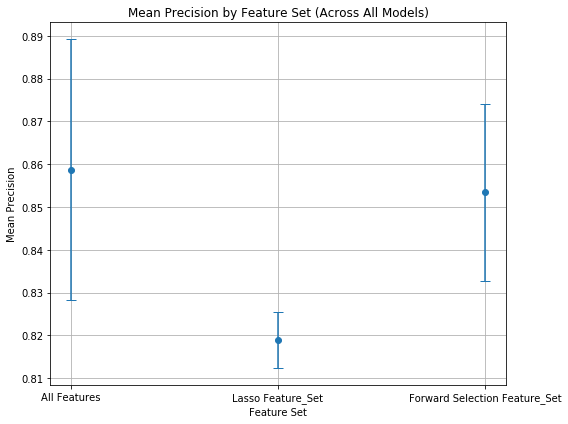

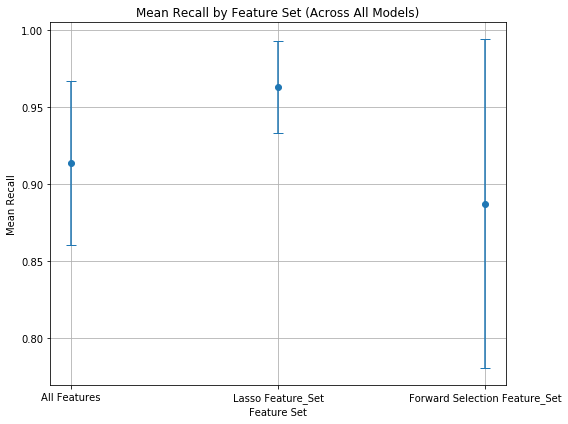

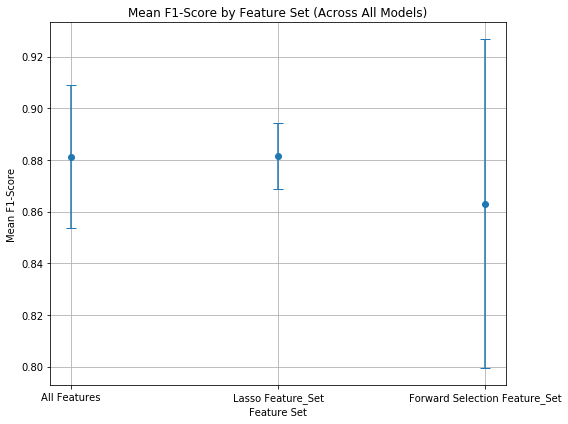

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Fonction pour calculer la moyenne des métriques et les écart-types sur tous les modèles pour chaque feature set
def plot_avg_metric_by_feature_set(metric_name, y_label):
    feature_sets = list(summary_data[next(iter(summary_data))]['Feature Set'])
    lop = ["All Features","Lasso Feature_Set","Forward Selection Feature_Set"]
    mean_metrics_by_feature_set = []
    std_metrics_by_feature_set = []
    
    # Calcul de la moyenne des métriques pour chaque feature set
    for feature_idx, feature_set in enumerate(feature_sets):
        metrics = [
            summary_data[model][f'Mean {metric_name}'].values[feature_idx] for model in summary_data
        ]
        mean_metrics_by_feature_set.append(np.mean(metrics))
        std_metrics_by_feature_set.append(np.std(metrics))

    # Affichage du graphique avec les barres d'erreur
    plt.figure(figsize=(8, 6))
    plt.errorbar(lop, mean_metrics_by_feature_set, yerr=std_metrics_by_feature_set, fmt='o', capsize=5)
    
    plt.title(f'Mean {y_label} by Feature Set (Across All Models)')
    plt.xlabel('Feature Set')
    plt.ylabel(f'Mean {y_label}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Génération du graphique pour chaque métrique
plot_avg_metric_by_feature_set('Accuracy', 'Accuracy')
plot_avg_metric_by_feature_set('Precision', 'Precision')
plot_avg_metric_by_feature_set('Recall', 'Recall')
plot_avg_metric_by_feature_set('F1-Score', 'F1-Score')
#plot_avg_metric_by_feature_set('ROC-AUC', 'ROC-AUC')

### Plotting in one graph

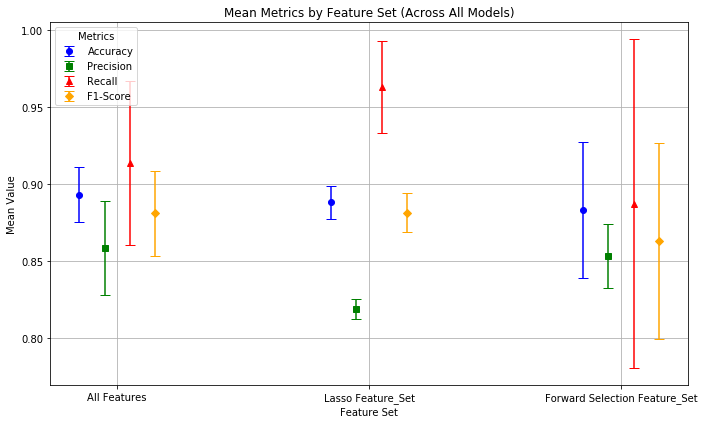

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the mean metrics and standard deviation across all models for each feature set
def plot_all_metrics_by_feature_set():
    feature_sets = list(summary_data[next(iter(summary_data))]['Feature Set'])
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    # Define distinct markers and colors for each metric
    markers = ['o', 's', '^', 'D']  # Circle, Square, Triangle, Diamond
    colors = ['b', 'g', 'r', 'orange']
    
    # Create an offset for each metric to avoid overlapping error bars
    x = np.arange(len(feature_sets))  # Original x-axis positions
    offsets = np.linspace(-0.15, 0.15, len(metrics))  # Create small shifts for each metric

    # Initialize the figure
    plt.figure(figsize=(10, 6))
    
    # Loop through each metric and compute mean and std for each feature set
    for idx, (metric_name, label) in enumerate(zip(metrics, metric_labels)):
        mean_metrics_by_feature_set = []
        std_metrics_by_feature_set = []
        
        # Calculate the mean and std for each feature set
        for feature_idx, feature_set in enumerate(feature_sets):
            metric_values = [
                summary_data[model][f'Mean {metric_name}'].values[feature_idx] for model in summary_data
            ]
            mean_metrics_by_feature_set.append(np.mean(metric_values))
            std_metrics_by_feature_set.append(np.std(metric_values))
        
        # Plot the metric with error bars, adding the offset to x-axis positions
        plt.errorbar(
            x + offsets[idx],  # Shift the x-axis positions by the offset
            mean_metrics_by_feature_set,
            yerr=std_metrics_by_feature_set,
            fmt=markers[idx],
            linestyle='',
            capsize=5,
            color=colors[idx],
            label=label
        )
    
    # Final adjustments to the plot
    plt.title('Mean Metrics by Feature Set (Across All Models)')
    plt.xlabel('Feature Set')
    plt.ylabel('Mean Value')
    plt.xticks(x, lop)  # Set the x-ticks to the original feature set labels
    plt.legend(title="Metrics", loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to generate the combined plot
plot_all_metrics_by_feature_set()


### Metrics for models independently of feature sets

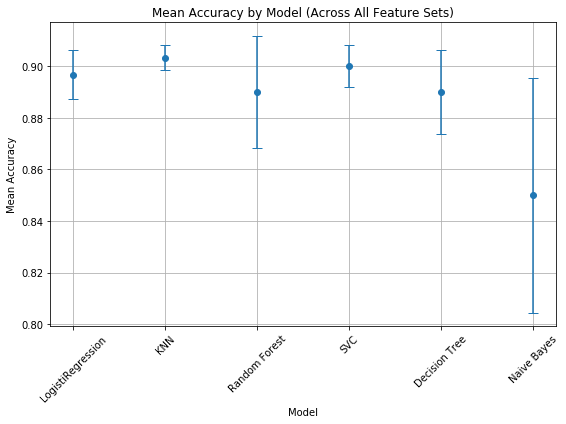

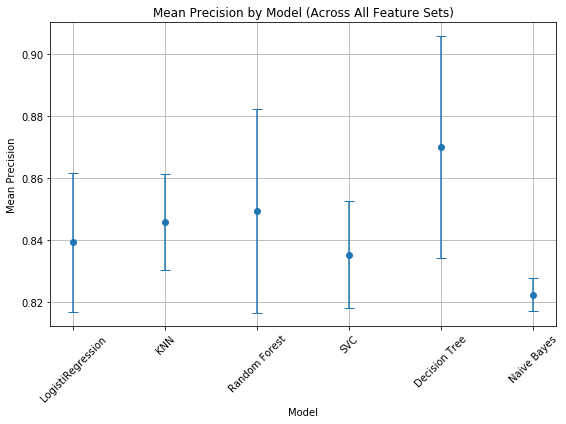

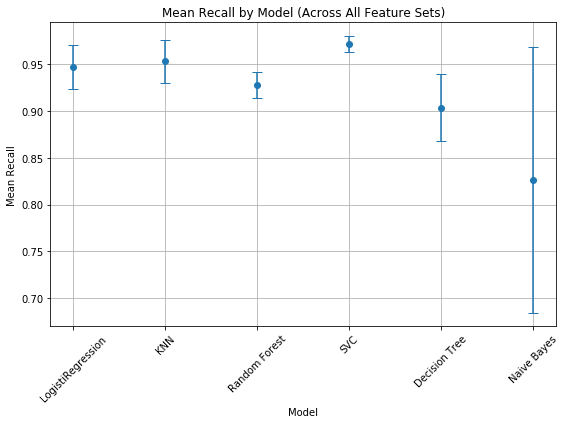

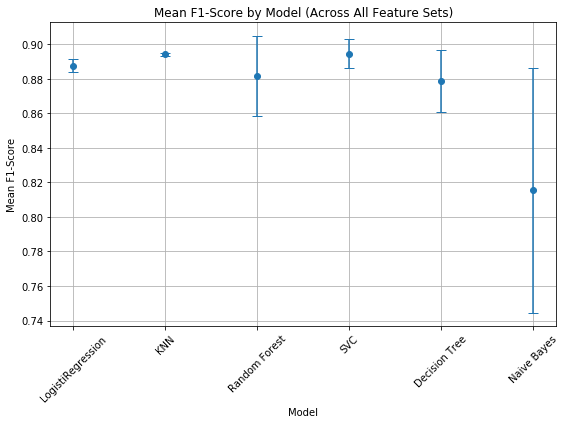

In [21]:
# Fonction pour calculer la moyenne des métriques et les écart-types pour chaque modèle (indépendamment des feature sets)
def plot_avg_metric_by_model(metric_name, y_label):
    models = list(summary_data.keys())
    
    mean_metrics_by_model = []
    std_metrics_by_model = []
    
    # Calcul de la moyenne des métriques pour chaque modèle
    for model in models:
        metrics = summary_data[model][f'Mean {metric_name}'].values
        mean_metrics_by_model.append(np.mean(metrics))
        std_metrics_by_model.append(np.std(metrics))

    # Affichage du graphique avec les barres d'erreur
    plt.figure(figsize=(8, 6))
    plt.errorbar(Almodel, mean_metrics_by_model, yerr=std_metrics_by_model, fmt='o', capsize=5)
    
    plt.title(f'Mean {y_label} by Model (Across All Feature Sets)')
    plt.xlabel('Model')
    plt.ylabel(f'Mean {y_label}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Génération du graphique pour chaque métrique
plot_avg_metric_by_model('Accuracy', 'Accuracy')
plot_avg_metric_by_model('Precision', 'Precision')
plot_avg_metric_by_model('Recall', 'Recall')
plot_avg_metric_by_model('F1-Score', 'F1-Score')
#plot_avg_metric_by_model('ROC-AUC', 'ROC-AUC')

### In one Paragraph

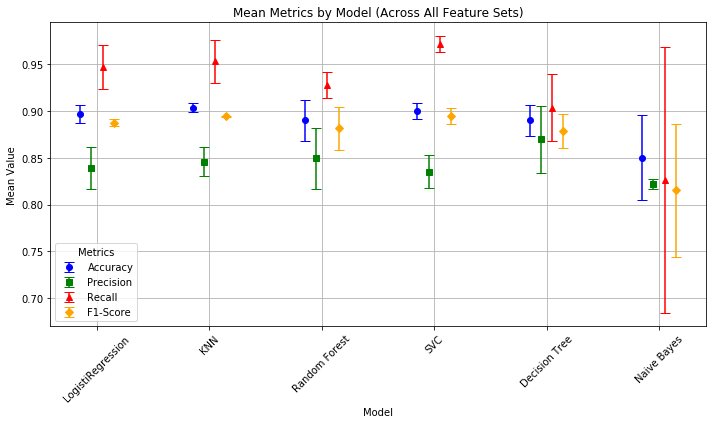

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer la moyenne des métriques et les écart-types pour chaque modèle (indépendamment des feature sets)
def plot_all_metrics_by_model():
    models = list(summary_data.keys())
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    # Define distinct markers and colors for each metric
    markers = ['o', 's', '^', 'D']  # Circle, Square, Triangle, Diamond
    colors = ['b', 'g', 'r', 'orange']
      # Different line styles for distinction
    
    # Create an offset for each metric to avoid overlapping error bars
    x = np.arange(len(models))  # Original x-axis positions (the models)
    offsets = np.linspace(-0.15, 0.15, len(metrics))  # Create small shifts for each metric

    # Initialize the figure
    plt.figure(figsize=(10, 6))
    
    # Loop through each metric and compute mean and std for each model
    for idx, (metric_name, label) in enumerate(zip(metrics, metric_labels)):
        mean_metrics_by_model = []
        std_metrics_by_model = []
        
        # Calculate the mean and std for each model
        for model in models:
            metric_values = summary_data[model][f'Mean {metric_name}'].values
            mean_metrics_by_model.append(np.mean(metric_values))
            std_metrics_by_model.append(np.std(metric_values))
        
        # Plot the metric with error bars, adding the offset to x-axis positions
        plt.errorbar(
            x + offsets[idx],  # Shift the x-axis positions by the offset
            mean_metrics_by_model,
            yerr=std_metrics_by_model,
            fmt=markers[idx],
            linestyle='',
            capsize=5,
            color=colors[idx],
            label=label
        )
    
    # Final adjustments to the plot
    plt.title('Mean Metrics by Model (Across All Feature Sets)')
    plt.xlabel('Model')
    plt.ylabel('Mean Value')
    plt.xticks(x, Almodel, rotation=45)  # Set the x-ticks to the model labels
    plt.legend(title="Metrics", loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to generate the combined plot for all metrics
plot_all_metrics_by_model()